## Dataset 1

### Text preprocessing

In [2]:
import re 
from collections import Counter

In [3]:
with open("Shakespeare.txt", "r") as f:
    text = f.read()

text = text.lower()
text = text.replace('\n', ' ')
text = re.sub(r'[-–—]+', ' ', text)
text = re.sub(r'[^a-zA-Z0-9 \. ]', '', text)
text = re.sub(r'\.', ' . ', text)

words = text.split()
word_freq = Counter(words)

print(f"The size of the vocabulary is: {len(set(words))}")
print("Top 10 most frequent words are:")
for word, freq in word_freq.most_common(10):
    print(word, ":", freq)

The size of the vocabulary is: 24159
Top 10 most frequent words are:
. : 33850
the : 26221
and : 23534
i : 20049
to : 18644
of : 16358
a : 13601
you : 13546
my : 12019
that : 10481


### Making Training Data

In [4]:
def make_data(words, context_window=3, pad_token="<PAD>"):
    X, y = [], []

    padded_words = [pad_token] * context_window + words

    for i in range(context_window, len(padded_words)):
        input_sequence = padded_words[i - context_window:i]
        target_word = padded_words[i]
        X.append(input_sequence)
        y.append(target_word)

    return X, y

X, y = make_data(words, context_window=3)

print(len(y))
for i in range(0,40):
    input_str = " ".join(X[i])
    output_str = y[i]
    print(f"{input_str} ---> {output_str}")

871364
<PAD> <PAD> <PAD> ---> first
<PAD> <PAD> first ---> citizen
<PAD> first citizen ---> before
first citizen before ---> we
citizen before we ---> proceed
before we proceed ---> any
we proceed any ---> further
proceed any further ---> hear
any further hear ---> me
further hear me ---> speak
hear me speak ---> .
me speak . ---> all
speak . all ---> speak
. all speak ---> speak
all speak speak ---> .
speak speak . ---> first
speak . first ---> citizen
. first citizen ---> you
first citizen you ---> are
citizen you are ---> all
you are all ---> resolved
are all resolved ---> rather
all resolved rather ---> to
resolved rather to ---> die
rather to die ---> than
to die than ---> to
die than to ---> famish
than to famish ---> all
to famish all ---> resolved
famish all resolved ---> .
all resolved . ---> resolved
resolved . resolved ---> .
. resolved . ---> first
resolved . first ---> citizen
. first citizen ---> first
first citizen first ---> you
citizen first you ---> know
first you kno

### Model

In [5]:
import torch
import torch.nn as nn

In [6]:
class NextTokenPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim=32, hidden_dim=128, n_layers=1, activation='relu', context_window=3, dropout_prob=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.context_window = context_window
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(p=dropout_prob)

        input_dim = embedding_dim * context_window
        for i in range(n_layers):
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            input_dim = hidden_dim

        self.activation = nn.ReLU() if activation == 'relu' else nn.Tanh()
        self.output = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.embedding(x)
        x = x.view(batch_size, -1)

        for layer in self.layers:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)

        logits = self.output(x)
        return logits


### Training Loop

In [7]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [8]:
vocab = set(words)
vocab.add('<PAD>')
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for w, i in word_to_idx.items()}

X_encoded = [[word_to_idx[w] for w in seq] for seq in X]
y_encoded = [word_to_idx[w] for w in y]

X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [9]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False):
        self.patience = patience        
        self.min_delta = min_delta      
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"  EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [10]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# model = NextTokenPredictor(len(vocab)).to(device)
# epochs = 200
# pad_idx = word_to_idx["<PAD>"]
# criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10)
# early_stopping = EarlyStopping(patience=3, min_delta=1e-4, verbose=True)


# train_losses, valid_losses = [], []

# for epoch in range(epochs):
#     model.train()
#     running_train_loss = 0.0

#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False, ncols=100)
#     for inputs, targets in progress_bar:
#         inputs, targets = inputs.to(device), targets.to(device)
#         optimizer.zero_grad()
#         logits = model(inputs)
#         loss = criterion(logits, targets)
#         loss.backward()
#         optimizer.step()

#         running_train_loss += loss.item()
#         progress_bar.set_postfix(loss=loss.item())

#     avg_train_loss = running_train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)

#     # Validation
#     model.eval()
#     running_valid_loss = 0.0
#     with torch.no_grad():
#         for inputs, targets in valid_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             logits = model(inputs)
#             loss = criterion(logits, targets)
#             running_valid_loss += loss.item()

#     avg_valid_loss = running_valid_loss / len(valid_loader)
#     valid_losses.append(avg_valid_loss)

#     torch.mps.synchronize()  

#     print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f}")

#     scheduler.step(avg_valid_loss)
#     early_stopping(avg_valid_loss)

#     if early_stopping.early_stop:
#         print("Early stopping triggered. Training halted.")
#         break


# # saving model 
# print("Saving Modelcheckpoints")
# os.makedirs("checkpoints", exist_ok=True)
# checkpoint_path = "checkpoints/dataset_shakespeare_cw3.pth"

# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'train_losses': train_losses,
#     'valid_losses': valid_losses,
# }, checkpoint_path)


In [11]:
# plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
# plt.plot(range(1, epochs+1), valid_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training vs Validation Loss')
# plt.legend()
# plt.grid()
# plt.show()


### Model inference

In [12]:
def sentence_to_tensor(sentence, word_to_idx):
    tokens = sentence.lower().split()
    unk_token = '<unk>'  
    unk_index = word_to_idx.get(unk_token)

    indices = []
    for token in tokens:
        idx = word_to_idx.get(token)
        if idx is None:
            if unk_index is not None:
                idx = unk_index
            else:
                raise ValueError(f"Token '{token}' not found in vocabulary and no unknown token defined.")
        indices.append(idx)

    input_tensor = torch.tensor([indices])
    return input_tensor


### Context window = 3

In [13]:
vocab_size = len(vocab)  
model1 = NextTokenPredictor(vocab_size)

checkpoint_path_cw3 = "/Users/oogway/CSE Courses/ML/Assingment-3/app/shakespeare_cw3.pth"  

checkpoint = torch.load(checkpoint_path_cw3, map_location=torch.device('mps'))
model1.load_state_dict(checkpoint['model_state_dict'])

model1.eval()

sentence = "my name king"
input_tensor = sentence_to_tensor(sentence, word_to_idx)

with torch.no_grad():
    output_logits1 = model1(input_tensor)

predicted_token_idx1 = torch.argmax(output_logits1, dim=1)
predicted_word1 = idx_to_word[predicted_token_idx1.item()]

print("Predicted next word model cw 3:", predicted_word1)


Predicted next word model cw 3: temptation


### Context window = 5

In [19]:
vocab_size = len(vocab)  
model2 = NextTokenPredictor(vocab_size, context_window=5)

checkpoint_path_cw5 = "/Users/oogway/CSE Courses/ML/Assingment-3/app/shakespeare_cw5.pth"  

checkpoint = torch.load(checkpoint_path_cw5, map_location=torch.device('mps'))
model2.load_state_dict(checkpoint['model_state_dict'])

model2.eval()

sentence = "what is my name queen"
input_tensor = sentence_to_tensor(sentence, word_to_idx)

with torch.no_grad():
    output_logits1 = model2(input_tensor)

predicted_token_idx1 = torch.argmax(output_logits1, dim=1)
predicted_word1 = idx_to_word[predicted_token_idx1.item()]

print("Predicted next word model cw 5:", predicted_word1)


Predicted next word model cw 5: dropped


### Embedding visualizations

In [20]:
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import numpy as np

# embeddings = model1.embedding.weight.data.cpu().numpy()

# selected_words = ['king', 'queen', 'man', 'woman', 'run', 'walk', 'fast', 'slow', 'happy', 'sad', 'he', 'she', 'cat', 'dog', 'table']
# word_categories = ['royalty', 'royalty', 'gender', 'gender', 'verbs', 'verbs', 'adverbs', 'adverbs', 'emotion', 'emotion', 'pronoun', 'pronoun', 'animal', 'animal', 'object']

# indices = [word_to_idx[word] for word in selected_words]
# selected_embeddings = embeddings[indices]

# tsne = TSNE(n_components=2, perplexity=5, random_state=42)
# emb_2d = tsne.fit_transform(selected_embeddings)

# plt.figure(figsize=(10, 8))
# colors = {'royalty': 'red', 'gender': 'blue', 'verbs': 'green', 'adverbs': 'purple', 'emotion': 'orange', 'pronoun': 'pink', 'animal': 'brown', 'object': 'gray'}

# for i, word in enumerate(selected_words):
#     plt.scatter(emb_2d[i, 0], emb_2d[i, 1], color=colors[word_categories[i]], label=word_categories[i] if word_categories[i] not in plt.gca().get_legend_handles_labels()[1] else "")
#     plt.text(emb_2d[i, 0]+0.1, emb_2d[i, 1]+0.1, word)

# plt.legend()
# plt.title('Word Embeddings Visualization with t-SNE context window 3')
# plt.show()


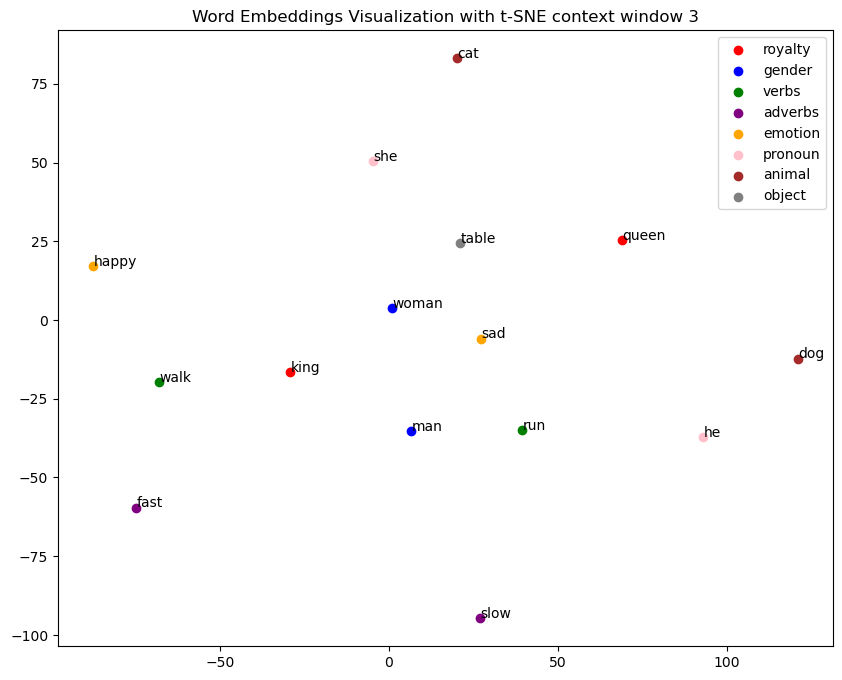

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

embeddings = model1.embedding.weight.data.cpu().numpy()

selected_words = ['king', 'queen', 'man', 'woman', 'run', 'walk', 'fast', 'slow', 
                  'happy', 'sad', 'he', 'she', 'cat', 'dog', 'table']
word_categories = ['royalty', 'royalty', 'gender', 'gender', 'verbs', 'verbs', 'adverbs', 'adverbs',
                   'emotion', 'emotion', 'pronoun', 'pronoun', 'animal', 'animal', 'object']


indices = []
words_found = []
for word in selected_words:
    idx = word_to_idx.get(word, word_to_idx.get('UNK', None))
    if idx is not None:
        indices.append(idx)
        words_found.append(word)
    else:
        print(f"Warning: '{word}' not in vocab and no UNK token.")

selected_embeddings = embeddings[indices]
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
emb_2d = tsne.fit_transform(selected_embeddings)

plt.figure(figsize=(10, 8))
colors = {'royalty': 'red', 'gender': 'blue', 'verbs': 'green', 'adverbs': 'purple',
          'emotion': 'orange', 'pronoun': 'pink', 'animal': 'brown', 'object': 'gray'}

used_labels = set()
for i, word in enumerate(words_found):
    category = word_categories[selected_words.index(word)]
    label = category if category not in used_labels else ""
    plt.scatter(emb_2d[i, 0], emb_2d[i, 1], color=colors[category], label=label)
    plt.text(emb_2d[i, 0]+0.1, emb_2d[i, 1]+0.1, word)
    used_labels.add(category)

plt.legend()
plt.title('Word Embeddings Visualization with t-SNE context window 3')
plt.show()


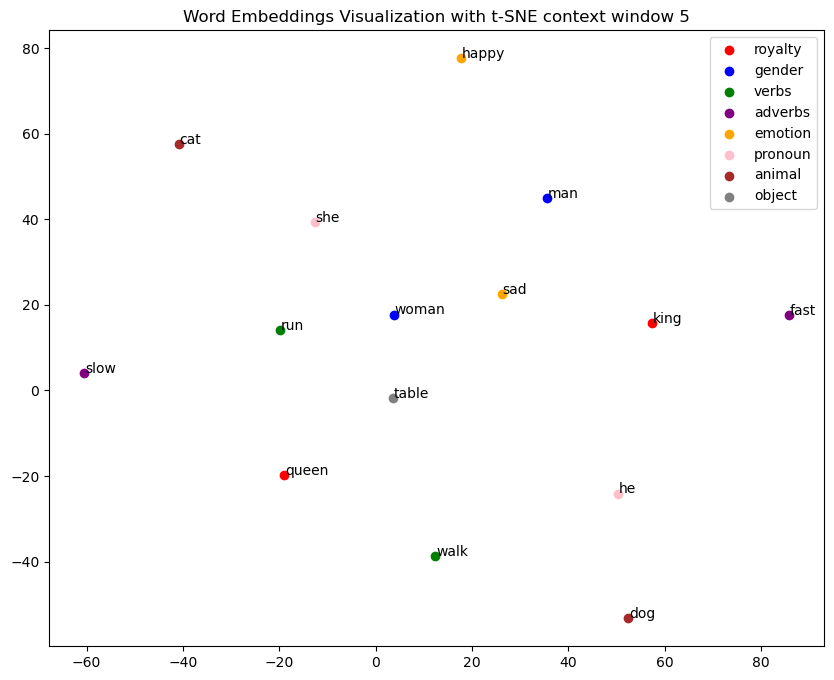

In [22]:
embeddings = model2.embedding.weight.data.cpu().numpy()

selected_words = ['king', 'queen', 'man', 'woman', 'run', 'walk', 'fast', 'slow', 
                  'happy', 'sad', 'he', 'she', 'cat', 'dog', 'table']
word_categories = ['royalty', 'royalty', 'gender', 'gender', 'verbs', 'verbs', 'adverbs', 'adverbs',
                   'emotion', 'emotion', 'pronoun', 'pronoun', 'animal', 'animal', 'object']


indices = []
words_found = []
for word in selected_words:
    idx = word_to_idx.get(word, word_to_idx.get('UNK', None))
    if idx is not None:
        indices.append(idx)
        words_found.append(word)
    else:
        print(f"Warning: '{word}' not in vocab and no UNK token.")

selected_embeddings = embeddings[indices]
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
emb_2d = tsne.fit_transform(selected_embeddings)

plt.figure(figsize=(10, 8))
colors = {'royalty': 'red', 'gender': 'blue', 'verbs': 'green', 'adverbs': 'purple',
          'emotion': 'orange', 'pronoun': 'pink', 'animal': 'brown', 'object': 'gray'}

used_labels = set()
for i, word in enumerate(words_found):
    category = word_categories[selected_words.index(word)]
    label = category if category not in used_labels else ""
    plt.scatter(emb_2d[i, 0], emb_2d[i, 1], color=colors[category], label=label)
    plt.text(emb_2d[i, 0]+0.1, emb_2d[i, 1]+0.1, word)
    used_labels.add(category)

plt.legend()
plt.title('Word Embeddings Visualization with t-SNE context window 5')
plt.show()
